In [12]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd


# Find project root and add 'src' folder to sys.path
project_root = Path.cwd().parents[0]  # goes from /notebooks/ to project root
src_path = project_root / 'src'
sys.path.append(str(src_path))

In [13]:
from data_fetching.fetch_yfinance import get_price_data

tickers = [
    #"MCD",   # McDonald's (largest fast food chain)
    "SBUX",  # Starbucks (global coffee leader)
    "CMG",   # Chipotle (fast-casual leader)
    "YUM",   # Yum! Brands (KFC, Taco Bell, Pizza Hut)
    "QSR",   # Restaurant Brands Int'l (Burger King, Popeyes, Tim Hortons)
    #"DPZ",   # Domino's Pizza (global pizza delivery leader)
    #"WEN",   # Wendy's (major burger chain)
    "SHAK",  # Shake Shack (premium fast-casual)
    "PZZA",  # Papa John's (pizza chain)
]
start_date = '2020-01-01'
end_date = '2025-05-31'

prices = get_price_data(tickers, start_date, end_date)
print(prices.info)

[*********************100%***********************]  6 of 6 completed

<bound method DataFrame.info of Ticker            CMG       PZZA        QSR       SBUX        SHAK         YUM
Date                                                                          
2020-01-02  17.163799  55.727379  53.804100  79.306686   61.130001   92.200241
2020-01-03  17.302601  56.108948  53.587894  78.845131   60.490002   91.911453
2020-01-06  17.160400  57.280289  52.481876  78.223793   59.560001   91.857300
2020-01-07  17.201599  56.490528  52.714718  77.984154   61.299999   92.019760
2020-01-08  17.134600  57.289162  51.899765  78.889511   62.029999   92.182190
...               ...        ...        ...        ...         ...         ...
2025-05-23  50.630001  42.250000  70.070000  84.400002  117.620003  144.740005
2025-05-27  50.990002  44.310001  71.599998  87.010002  126.349998  144.089996
2025-05-28  50.070000  43.590000  71.800003  86.000000  126.570000  143.149994
2025-05-29  49.730000  43.820000  70.699997  84.050003  126.639999  144.039993
2025-05-30  50.08000

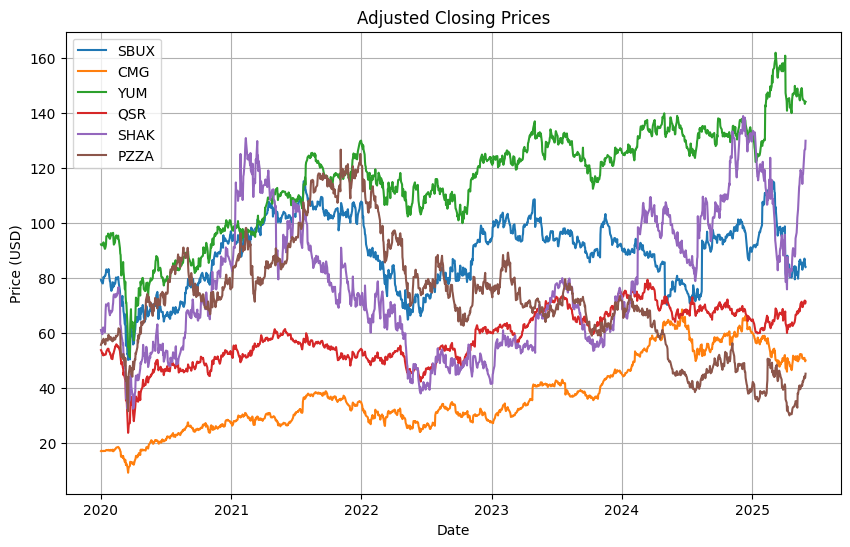

In [14]:
#Matplotlib adjusted closing price visualization
plt.figure(figsize=(10,6))
for ticker in tickers:
    plt.plot(prices.index, prices[ticker], label=ticker)

plt.title('Adjusted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

This is all well and good but to do a proper portfolio optimization program, we need returns data, not prices data. That was just practice. To use Markowitz's Model, we need to understand these key concepts:
<br>
1. <b>Expected Return (Mean Return):</b> Average return you expect from an asset over time
<br>
2. <b>Risk (Covariance and Standard Deviation):</b> How much returns fluctuate. More variance = more risk.
<br>
3.<b>Covariance / Correlation:</b> How two assets move relative to each other. If they move perfectly together (correlation = 1), diversification benefits are low. If they move differently or opposite (correlation < 1), risk can be reduced by combining them.
<br>
4. <b>Porfolio Return:</b> Weighted sum of expected returns
<br>
5. <b>Portfolio Variance:</b> Weighted sum of variances and covariances, capturing total risk.
<br>
<br>
Now that we understand those key concepts, we need the following data:
<br>
- Returns data, not prices — Returns measure percentage change day-to-day (or whatever frequency you choose).
<br>
- Mean returns vector — average return per asset.
<br>
- Covariance matrix — measures how asset returns move together.

In [15]:
#Calculations
returns = prices.pct_change().dropna() #Percentage change in prices of chosen stocks day to day, drops NaN (first row)
mean_returns = returns.mean() #Mean Returns
cov_matrix = returns.cov() #CoVariance Matrix
print(returns)
print(mean_returns)
print(cov_matrix)

Ticker           CMG      PZZA       QSR      SBUX      SHAK       YUM
Date                                                                  
2020-01-03  0.008087  0.006847 -0.004018 -0.005820 -0.010469 -0.003132
2020-01-06 -0.008218  0.020876 -0.020639 -0.007880 -0.015374 -0.000589
2020-01-07  0.002401 -0.013788  0.004437 -0.003064  0.029214  0.001769
2020-01-08 -0.003895  0.014137 -0.015460  0.011610  0.011909  0.001765
2020-01-09  0.006933  0.011152  0.006569  0.018564 -0.014025  0.007929
...              ...       ...       ...       ...       ...       ...
2025-05-23 -0.002954 -0.006584  0.009218  0.005121  0.002814 -0.000344
2025-05-27  0.007110  0.048757  0.021835  0.030924  0.074222 -0.004491
2025-05-28 -0.018043 -0.016249  0.002793 -0.011608  0.001741 -0.006524
2025-05-29 -0.006790  0.005276 -0.015320 -0.022674  0.000553  0.006217
2025-05-30  0.007038  0.032634  0.010043 -0.001190  0.024874 -0.000694

[1359 rows x 6 columns]
Ticker
CMG     0.001041
PZZA    0.000232
QSR     0.0

Now that we have calculated these numbers, we will build a basic model that maximizes <b>sharpe ratio</b>. 
<br>
<br>
### **What is Sharpe Ratio?**
Sharpe Ratio = (Portfolio Return - Risk Free Rate)/Portfolio Risk (or Standard Deviation)
<br>
<br>
-Portfolio Return: How much your portfolio is expected to grow
<br>
-Risk-Free Rate: What you'd earn doing nothing risky (e.g., government bonds)
<br>
-Portfolio Risk: How much the returns bounce around (volatility)
<br>
The Sharpe ratio measures how much return you're getting for each unit of risk you take.
<br>
| Sharpe Ratio | Interpretation           |
| ------------ | ------------------------- |
| < 1.0        | Poor risk-adjusted return |
| \~1.0        | Acceptable                |
| > 1.0        | Good                      |
| > 2.0        | Very Good                 |
| > 3.0        | Excellent                 |

### **Volatility Classification (Annualized Standard Deviation)**  
*(For stocks/portfolios, based on historical equity markets)*  

| Volatility Range  | Classification       | Interpretation                          | Example Assets                          |
|-------------------|----------------------|-----------------------------------------|-----------------------------------------|
| **< 10%**         | Very Low Volatility  | Cash-like stability                    | T-bills, utility stocks, low-vol ETFs  |
| **10–15%**        | Low Volatility       | Defensive, low sensitivity to markets  | Consumer staples, blue-chip dividends  |
| **15–20%**        | Moderate Volatility  | Typical diversified portfolio          | S&P 500, balanced mutual funds        |
| **20–30%**        | High Volatility      | Aggressive growth/sector risk          | Tech stocks, small-caps               |
| **30–50%**        | Very High Volatility | Speculative, large swings              | Meme stocks, crypto, biotech          |
| **> 50%**         | Extreme Volatility   | Casino-level risk                      | Penny stocks, 3x leveraged ETFs       |

### **Notes:**  
- **S&P 500** historically: ~15–20%  
- **Bonds**: 5–10% | **Crypto (BTC)**: 60–100%  
- High volatility (>25%) = common for single stocks, rare for diversified portfolios.  



In [16]:
import numpy as np

#Sharpe Ratio Function (Also stored in src/analysis/sharpe_analysis.py, I put it here just for showcase purposes)
def calc_sharpe_ratio(total_investment, tickers, weights, mean_returns, cov_matrix, trading_days, risk_free_rate=0.044):
    portfolio_return = np.dot(weights, mean_returns) * trading_days #np.dot used for multiplication, if array are both 2D then it does matrix multiplication. already annualized.
    
    portfolio_volatility = (np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(trading_days))*100 #percentage
    
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility #calculates Sharpe Ratio

    weights_df = pd.DataFrame(data=weights, index=tickers, columns=['Weight']) #how much weight each asset has

    weights_df['Weight'] = weights_df['Weight'] * 100  # convert to percent

    # Calculate dollar allocation per stock
    weights_df['USD Allocation'] = weights_df['Weight'] * total_investment

    # Reorder columns for clarity
    weights_df = weights_df[['Weight', 'USD Allocation']]

    weights_df['Projected Return ($)'] = portfolio_return*weights_df['USD Allocation']
    weights_df = weights_df[['Weight', 'USD Allocation', 'Projected Return ($)']]

    total_projected_return_usd = weights_df['Projected Return ($)'].sum()


    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

    
    if sharpe_ratio < 1.0:
        print("Sharpe Ratio Intepretation: Poor risk adjusted return")
    elif sharpe_ratio == 1.0:
        print("Sharpe Ratio Intepretation: Acceptable")
    elif sharpe_ratio > 1.0:
        print("Sharpe Ratio Intepretation: Good")
    elif sharpe_ratio > 2.0:
        print("Sharpe Ratio Intepretation: Very good")
    elif sharpe_ratio > 3.0:
        print("Sharpe Ratio Intepretation: Excellent")
    

    print(f"Portfolio Return: {portfolio_return:.4f}")

    print(f"Portfolio Volatility: {portfolio_volatility:.4f}%")

    if portfolio_volatility < 10:
        print("Volatility Intepretation: Cash-like stability")
    elif portfolio_volatility < 15:
        print("Volatility Intepretation: Defensive, low sensitivity to markets")
    elif portfolio_volatility < 20:
        print("Volatility Intepretation: Typical diversified portfolio")
    elif portfolio_volatility < 30:
        print("Volatility Intepretation: Aggressive growth/sector risk ")
    elif portfolio_volatility < 50:
        print("Volatility Intepretation: Speculative, large swings")
    elif portfolio_volatility > 50:
        print("Volatility Intepretation: Casino-level risk")
    
    print("Portfolio Weights (%):")
    
    print(weights_df)

    print(f"Total Projected Returns ($): {total_projected_return_usd:.2f}")



In [17]:
#We will now call the function here.
trading_days = prices.shape[0]
total_investment = 1000 #USD amount we are investing

n = len(mean_returns)
weights = np.array([1/n] * n) #How much of each stock we are buying essentially. (assuming we buy equal amounts of each stock)

from analysis.sharpe_analysis import calc_sharpe_ratio

calc_sharpe_ratio(
    total_investment=10000,
    tickers=tickers,
    weights=weights,
    mean_returns=mean_returns,
    cov_matrix=cov_matrix,
    trading_days=trading_days
)


Sharpe Ratio: 0.0121
Sharpe Ratio Intepretation: Poor risk adjusted return
Portfolio Return: 0.8145
Portfolio Volatility: 63.8465%
Volatility Intepretation: Casino-level risk
Portfolio Weights (%):
         Weight  USD Allocation  Projected Return ($)
SBUX  16.666667   166666.666667         135744.701895
CMG   16.666667   166666.666667         135744.701895
YUM   16.666667   166666.666667         135744.701895
QSR   16.666667   166666.666667         135744.701895
SHAK  16.666667   166666.666667         135744.701895
PZZA  16.666667   166666.666667         135744.701895
Total Projected Returns ($): 814468.21


This is awesome and all, but, we need to actually make this program optimize the weights on its own to make it a Portfolio "Optimizer", so let's do that

In [19]:
from optimization.markowitz import optimize_portfolio

weights_df = optimize_portfolio(mean_returns, cov_matrix, tickers)
print(weights_df)

      Weight (%)
SBUX         0.0
CMG          0.0
YUM          0.0
QSR          0.0
SHAK       100.0
PZZA         0.0
